# Выбор локации для скважины

Есть добывающая компания «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.
____

**Описание данных:** Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.

**Признаки:**

* **id** — уникальный идентификатор скважины;
* **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
* **product** — объём запасов в скважине (тыс. баррелей).
____

**Задача:** Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*
____

**Цель:** Найти наилучший регион для бурения новой скважины. 
____

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.
____

**Содержание:**
1. [Загрузка и подготовка данных](#1)
2. [Обучение и проверка модели](#2)
3. [Подготовка к расчету прибыли](#3)
4. [Расчет прибыли и рисков](#4)
5. [Общие выводы](#5)

## <a id=1>Загрузка и подготовка данных</a>

In [2]:
#Подгружаем необходимые библиотеки для работы с данными и машинного обучения
import warnings
import timeit
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             f1_score, 
                             roc_curve, 
                             roc_auc_score, 
                             confusion_matrix)
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats as st

#Подгружаем дополнительные полезные библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
#Уберем warnings, чтобы не мешали
warnings.filterwarnings("ignore")

In [4]:
#Загружаем файлы с данными
try:
    data0= pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Спринт 8. Машинное обучение в бизнесе/geo_data_0.csv')
    data1= pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Спринт 8. Машинное обучение в бизнесе/geo_data_1.csv')
    data2= pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Спринт 8. Машинное обучение в бизнесе/geo_data_2.csv')
except:
    data0 = pd.read_csv('/datasets/geo_data_0.csv')
    data1 = pd.read_csv('/datasets/geo_data_1.csv')
    data2 = pd.read_csv('/datasets/geo_data_2.csv')

In [5]:
#Проверяем каждый из них
data0.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [6]:
data1.head(10)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [7]:
data2.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


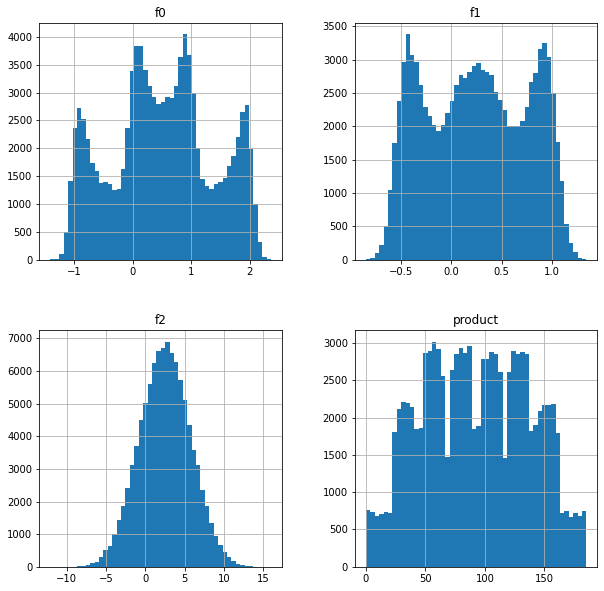

In [8]:
#Выведем информацию о каждом датафрейме и гистограммы
data0.info()
data0.hist(figsize=(10,10), bins=50);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


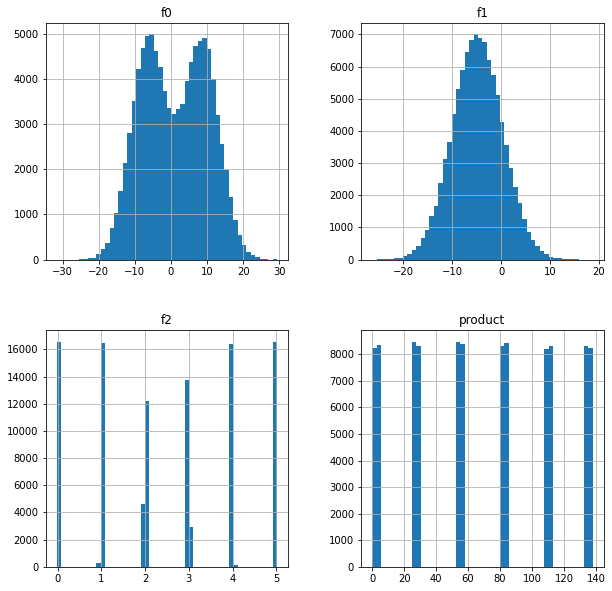

In [9]:
data1.info()
data1.hist(figsize=(10,10), bins=50);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


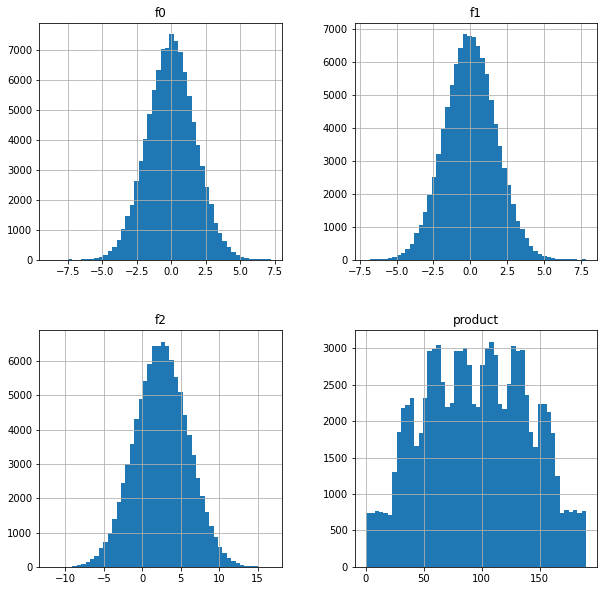

In [10]:
data2.info()
data2.hist(figsize=(10,10), bins=50);

Пропущенных значений, проблем с типом данных и вылетов **не обнаружено** во всех датафреймах.

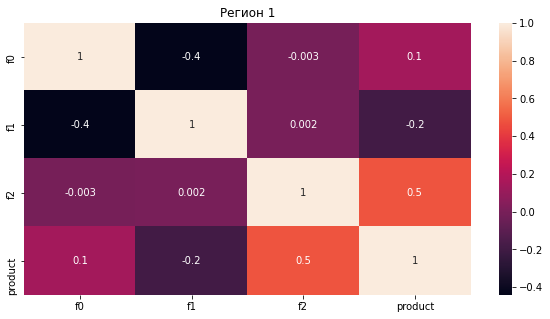

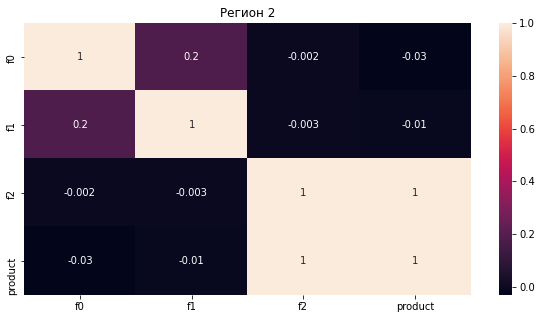

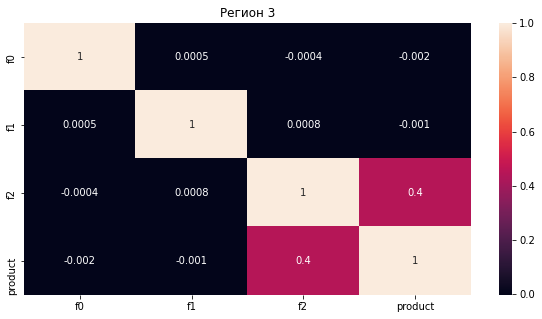

In [11]:
#Выведем тепловую карту, чтобы понять, какие параметры наибольшим образом коррелируют между собой
plt.figure(figsize = (10,5))
plt.title('Регион 1')
sns.heatmap(data0.corr(), annot=True, fmt='.1g');
plt.figure(figsize = (10,5))
plt.title('Регион 2')
sns.heatmap(data1.corr(), annot=True, fmt='.1g');
plt.figure(figsize = (10,5))
plt.title('Регион 3')
sns.heatmap(data2.corr(), annot=True, fmt='.1g');

In [12]:
#Уберем из датафреймов ID скважин, они не понадобятся в обучении и прогнозе модели
data0 = data0.drop(['id'], axis=1)
data1 = data1.drop(['id'], axis=1)
data2 = data2.drop(['id'], axis=1)

In [13]:
#Выведем теперь параметр VIF для поиска коллинеарных признаков 
vif_data0 = pd.DataFrame()
vif_data0['feature'] = data0.columns
vif_data0['VIF'] = [variance_inflation_factor(data0.values, i) for i in range(len(data0.columns))]
vif_data0

,feature,VIF
0,f0,1.534241
1,f1,1.275466
2,f2,2.072358
3,product,2.828466


In [14]:
vif_data1 = pd.DataFrame()
vif_data1['feature'] = data1.columns
vif_data1['VIF'] = [variance_inflation_factor(data1.values, i) for i in range(len(data1.columns))]
vif_data1

,feature,VIF
0,f0,1.987320
1,f1,1.828240
2,f2,4660.924529
3,product,4692.553526


In [15]:
vif_data2 = pd.DataFrame()
vif_data2['feature'] = data2.columns
vif_data2['VIF'] = [variance_inflation_factor(data2.values, i) for i in range(len(data2.columns))]
vif_data2

,feature,VIF
0,f0,1.000000
1,f1,1.000004
2,f2,1.870123
3,product,1.870127


**Выводы:**

1) Данные выглядят без вылетов, пропущенных значений нету;\
2) Для Региона 1, Региона 2 и Региона 3 достаточно сильно связаны между собой параметры f2 и объем запасов нефти. Особенно это наблюдается для Региона 2, где эти параметры между собой имеют прямую корреляцию.

## <a id=2>Обучение и проверка модели</a>

In [16]:
#Разделим датафреймы на выборки в соотношении 75:25
features_0 = data0.drop('product', axis=1)
features_1 = data1.drop('product', axis=1)
features_2 = data2.drop('product', axis=1)

target_0 = data0['product']
target_1 = data1['product']
target_2 = data2['product']

features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=12345)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)

print('Регион 1')
print(features_train_0.shape)
print(target_train_0.shape)
print(features_valid_0.shape)
print(target_valid_0.shape)
print('-' * 10)

print('Регион 2')
print(features_train_0.shape)
print(target_train_0.shape)
print(features_valid_0.shape)
print(target_valid_0.shape)
print('-' * 10)

print('Регион 3')
print(features_train_0.shape)
print(target_train_0.shape)
print(features_valid_0.shape)
print(target_valid_0.shape)

Регион 1
(75000, 3)
(75000,)
(25000, 3)
(25000,)
----------
Регион 2
(75000, 3)
(75000,)
(25000, 3)
(25000,)
----------
Регион 3
(75000, 3)
(75000,)
(25000, 3)
(25000,)


In [17]:
#Обучим модели линейной регрессии для каждого датафрейма
model_0 = LinearRegression()
model_1 = LinearRegression()
model_2 = LinearRegression()

model_0.fit(features_train_0, target_train_0) 
model_1.fit(features_train_1, target_train_1) 
model_2.fit(features_train_2, target_train_2) 

predictions_0 = model_0.predict(features_valid_0) 
predictions_1 = model_1.predict(features_valid_1) 
predictions_2 = model_2.predict(features_valid_2) 

In [18]:
#Найдем средний запас прогнозного сырья и RMSE для каждого региона
mean_prod_0 = predictions_0.mean()
mean_prod_1 = predictions_1.mean()
mean_prod_2 = predictions_2.mean()

print('Средний запас прогнозного сырья для Региона 1:', mean_prod_0)
print('Средний запас прогнозного сырья для Региона 2:', mean_prod_1)
print('Средний запас прогнозного сырья для Региона 3:', mean_prod_2)

print('-' * 20)

RMSE_0 = mean_squared_error(target_valid_0, predictions_0) ** 0.5
RMSE_1 = mean_squared_error(target_valid_1, predictions_1) ** 0.5
RMSE_2 = mean_squared_error(target_valid_2, predictions_2) ** 0.5

print('RMSE для Региона 1:', RMSE_0)
print('RMSE для Региона 2:', RMSE_1)
print('RMSE для Региона 3:', RMSE_2)

Средний запас прогнозного сырья для Региона 1: 92.59256778438035
Средний запас прогнозного сырья для Региона 2: 68.728546895446
Средний запас прогнозного сырья для Региона 3: 94.96504596800489
--------------------
RMSE для Региона 1: 37.5794217150813
RMSE для Региона 2: 0.893099286775617
RMSE для Региона 3: 40.02970873393434


In [19]:
#Создадим набор правильных прогнозных значений, примем, что это значения, 
#у которых разница c фактическими значениями меньше, чем RMSE

predictions_0_pd = pd.Series(predictions_0)
predictions_1_pd = pd.Series(predictions_1)
predictions_2_pd = pd.Series(predictions_2)

right_predict_0 = predictions_0_pd.loc[abs(predictions_0_pd - target_valid_0) < RMSE_0]
right_predict_1 = predictions_1_pd.loc[abs(predictions_1_pd - target_valid_1) < RMSE_1]
right_predict_2 = predictions_2_pd.loc[abs(predictions_2_pd - target_valid_2) < RMSE_2]

print(right_predict_0.shape)
print(right_predict_1.shape)
print(right_predict_2.shape)

(3135,)
(363,)
(3307,)


**Выводы:**

1) Обучены модели линейной регрессии для прогнозирования запасов прогнозного сырья;\
2) Найдены RMSE каждой модели и средний запас прогнозного сырья для каждого региона. Регион 1 и 3 сильно похожи между собой. Для Региона 2 наблюдается наименьшее количество запасов при очень малом RMSE (самая точная модель).  

## <a id=3>Подготовка к расчёту прибыли</a>

Итак, приступим к расчёту прибыли. Но для начала для каждого вводного параметра зададим переменную:
* **all_points** - количество всех рассматриваемых точек (по условию задачи 500)
* **best_points** - количество лучших точек, куда будем бурить скважину (по условию задачи 200)
* **expenses** - затраты на бурение скважин (по условию задачи 10 млрд рублей)
* **income_for_1000barrel** - доход с 1000 баррелей нефти (по условию задачи 450 тыс. рублей) 

Вводить Налог на полезные ископаемые (НДПИ) не будем, так как этот параметр очень вариативен и зависит от того, какие параметры коллектора у месторождения и какие свойства добываемой нефти (льготный объект или нет). Примерно он 20% на добычу обычной нефти, но по услвоию задачи никаких вводных не было, поэтому НДПИ рассчитывать не будем и примем, что он учтен в доходе с 1000 баррелей нефти. 

In [20]:
#Заведем переменные для вводных параметров
ALL_POINTS = 500
BEST_POINTS = 200
EXPENSES = 10*10**9
INCOME_FOR_1000BARREL = 450000

#Найдем, сколько в среднем будет стоить бурение одной скважины
expenses_per_well = EXPENSES / BEST_POINTS

#Найдем, сколько потребуется добыть нефти, чтобы выйти в 0
prod_per_well = expenses_per_well / INCOME_FOR_1000BARREL

print('Средняя стоимость бурения одной скважины', expenses_per_well)
print('Безубыточный объем добычи нефти', round(prod_per_well, 3))

Средняя стоимость бурения одной скважины 50000000.0
Безубыточный объем добычи нефти 111.111


**Выводы:**

Безубыточный объем добычи нефти составил 111.111 тыс. баррелей, что выше, чем среднее количество запасов, приходящееся на одну скважину.  

## <a id=4>Расчёт прибыли и рисков</a> 

Напишем функцию для нахождения прибыли в млн рублей, учитывая скважины с максимальными правильнымии прогнозными значениями запасов нефти.  

In [21]:
#Исправим индексы для target
target_valid_0 = target_valid_0.reset_index(drop=True)
target_valid_1 = target_valid_1.reset_index(drop=True)
target_valid_2 = target_valid_2.reset_index(drop=True)

In [22]:
#Функция для расчета прибыли
def profit(predict, target, count, income, expenses):
    predict_sorted = predict.sort_values(ascending=False)[:count]
    selected_target = target[predict_sorted.index]
    return (income * selected_target.sum() - expenses)/10**6

In [23]:
#Применим бутстреп с 1000 выборок

state = np.random.RandomState(12345)

def bootstrap(predict, target, count, num, income, expenses):
    values = []
    for i in range(1000):
        subtarget = target.sample(n=ALL_POINTS, replace=True, random_state=state)
        subpredict = predict[subtarget.index]
        values.append(profit(subpredict, subtarget, count, income, expenses))
    values = pd.Series(values)
    loss = round(values[values < 0].count() / values.count() * 100, 3)
    quantile_1 = round(values.quantile(0.025), 3)
    quantile_2 = round(values.quantile(0.975), 3)
    mean = round(values.mean(), 3)
    print(f'Средняя прибыль Региона {num+1}: {mean}')
    print(f'Интервал 95% Региона {num+1}: {quantile_1}, {quantile_2}')
    print(f'Риск убытков Региона {num+1}: {loss}')
    print('-'*20)
   
bootstrap(predictions_0_pd, target_valid_0, BEST_POINTS, 0, INCOME_FOR_1000BARREL, EXPENSES) 
bootstrap(predictions_1_pd, target_valid_1, BEST_POINTS, 1, INCOME_FOR_1000BARREL, EXPENSES) 
bootstrap(predictions_2_pd, target_valid_2, BEST_POINTS, 2, INCOME_FOR_1000BARREL, EXPENSES) 

Средняя прибыль Региона 1: 600.735
Интервал 95% Региона 1: 12.948, 1231.164
Риск убытков Региона 1: 2.0
--------------------
Средняя прибыль Региона 2: 663.959
Интервал 95% Региона 2: 206.476, 1191.198
Риск убытков Региона 2: 0.1
--------------------
Средняя прибыль Региона 3: 597.381
Интервал 95% Региона 3: 1.735, 1246.218
Риск убытков Региона 3: 2.5
--------------------


**Выводы:**

Регион 2 является наиболее предпочтительным по величине прибыли (663.959 млн рублей) и риску убытков (0.1%). 

## <a id=5>Общие выводы</a>

**1. Загрузка и подготовка данных**:
* Данные выглядят без вылетов, пропущенных значений нету;\
* Для Региона 1, Региона 2 и Региона 3 достаточно сильно связаны между собой параметры f2 и объем запасов нефти. Особенно это наблюдается для Региона 2, где эти параметры между собой имеют прямую корреляцию.
------

**2. Обучение и проверка модели**:

* Обучены модели линейной регрессии для прогнозирования запасов прогнозного сырья;\
* Найдены RMSE каждой модели и средний запас прогнозного сырья для каждого региона. Регион 1 и 3 сильно похожи между собой. Для Региона 2 наблюдается наименьшее количество запасов при очень малом RMSE (самая точная модель).  

------

**3. Подготовка к расчету прибыли**:

* Безубыточный объем добычи нефти составил 111.111 тыс. баррелей, что выше, чем среднее количество запасов, приходящееся на одну скважину.  

------

**4. Расчет рисков и прибыли**:

* Регион 2 является наиболее предпочтительным по величине прибыли (663.959 млн рублей) и риску убытков (0.1%). 